In [ ]:
import pandas as pd

In [13]:
df = pd.read_csv("data/data.csv")

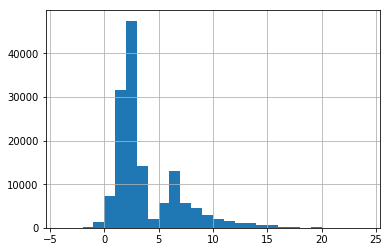

In [20]:
%matplotlib inline
import numpy as np
df[df.target_minutes>30].target.hist(bins=np.arange(-4,25))

In [21]:
df.minu

,Unnamed: 0,appearances,appearances_ewma,appearances_mean10,appearances_mean3,appearances_mean5,appearances_mean_all,appearances_sum_all,big_chances_created,big_chances_missed,...,goals_scored_team_pos_last3,goals_conceded_team_pos_last3,bps_team_pos_last3,total_points_target_team_pos_last3,goals_scored_target_team_pos_last3,goals_conceded_target_team_pos_last3,bps_target_team_pos_last3,bayes_global,bayes_team,bayes_team_pos
0,0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,0.0,0.0
1,1,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,0.0,0.0
2,2,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,0.0,0.0
3,3,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,0.0,0.0
4,4,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,0.0,0.0


In [37]:
y = df.target_minutes.dropna() > 60
X = df[df.columns[df.columns.str.startswith("appear")]].loc[y.index]

In [28]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
p = cross_val_predict(XGBClassifier(n_estimators=16, learning_rate=0.4), X, y, method="predict_proba")
log_loss(y, p), roc_auc_score(y, p[:,1])

(0.36944245830312333, 0.89814790118807941)

In [67]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
dfreg = df.loc[y[y==1].index]

features = [
    "last_season_ppm",
    "target_home",
    "goals_conceded_target_team_mean",
    "target_team",
    "last_season_points",
]
Xreg = dfreg[features]
yreg = dfreg.target
Xreg.shape, yreg.shape

((131008, 5), (131008,))

In [68]:
p = cross_val_predict(XGBRegressor(n_estimators=16, learning_rate=0.4), Xreg, yreg)
mean_squared_error(yreg, p) ** 0.5

3.0421766555089342

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, PolynomialFeatures

In [85]:
model = make_pipeline(Imputer(), MinMaxScaler(), PolynomialFeatures(), LogisticRegression(C=1e6))

In [86]:
p = cross_val_predict(model,
                      Xreg, yreg.clip(-1, 10), method="predict_proba")

/home/joe/upwork/.env/lib/python3.5/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [87]:
log_loss(yreg.clip(-1, 10), p), np.argmax(p, axis=1)

(2.0003388137623532, array([3, 3, 3, ..., 3, 3, 3]))

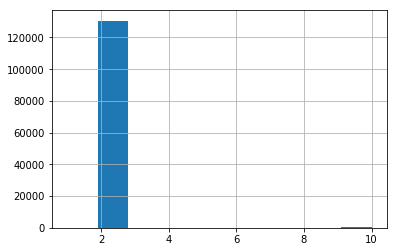

In [78]:
pd.Series(np.argmax(p, axis=1)-1).hist()

In [72]:
mean_squared_error(yreg, p.mean(axis=1)-1)

29.542666294483649

In [ ]:
p * np.arange(-1, 10)

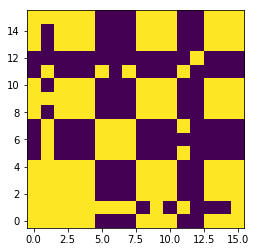

xgb                        0.971355
xgb_grouped                0.898069
xgb_reduced_last season    0.971381
xgb_reduced_10_games       0.971355
rf                         0.959874
linear                     0.776909
grouped_linear             0.850943
reduced_linear             0.750376
linear2                    1.000000
grouped_linear2            0.987929
reduced_linear2            0.999999
polynomial_fs              0.853759
simple_mean                0.701546
bayes_global_prior         0.932991
bayes_position_prior       0.935183
mean_model                 0.966878
Name: linear2, dtype: float64

In [18]:
import matplotlib.pyplot as plt
plt.imshow(df.corr()>0.9, origin="lower")
plt.show()
df.corr()["linear2"]

In [15]:
df.loc[df["season"]==2016, ["target_team", "team_code", "opponent_team", "season"]].head(1000).tail()

,target_team,team_code,opponent_team,season
995,NaN,3,NaN,2016.0
996,NaN,3,NaN,2016.0
997,NaN,3,NaN,2016.0
998,NaN,3,NaN,2016.0
999,NaN,3,NaN,2016.0


In [6]:
import pandas as pd
%matplotlib inline
df = pd.read_csv("data/validation_scores.csv", index_col=0)
cols = df.ewm(10).mean().iloc[-1].sort_values().iloc[:10].index

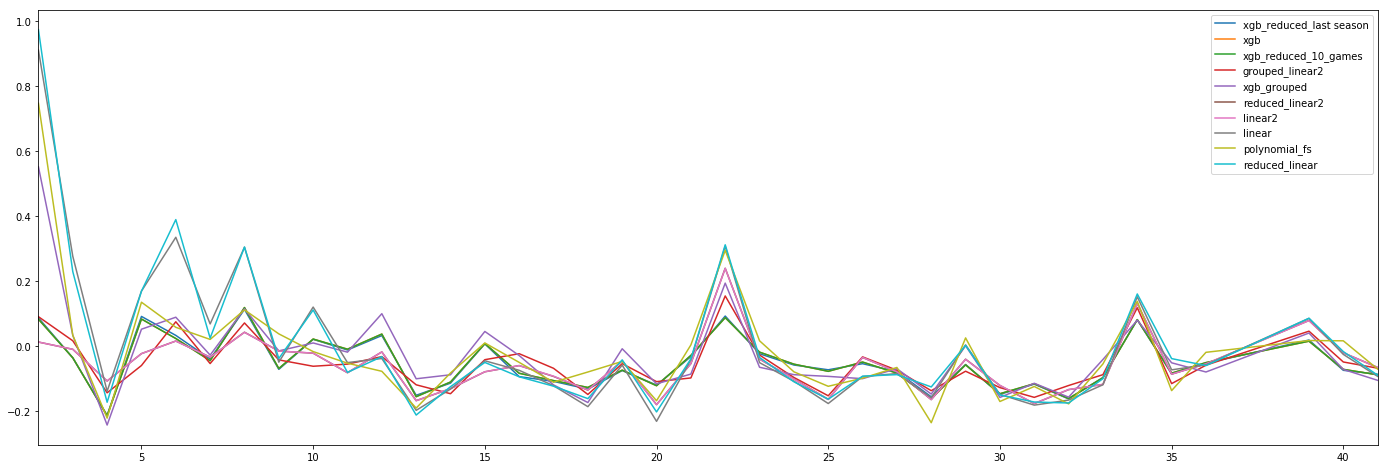

In [7]:
df.sub(df["bayes_global_prior"], axis=0)[cols].plot(figsize=(24, 8))

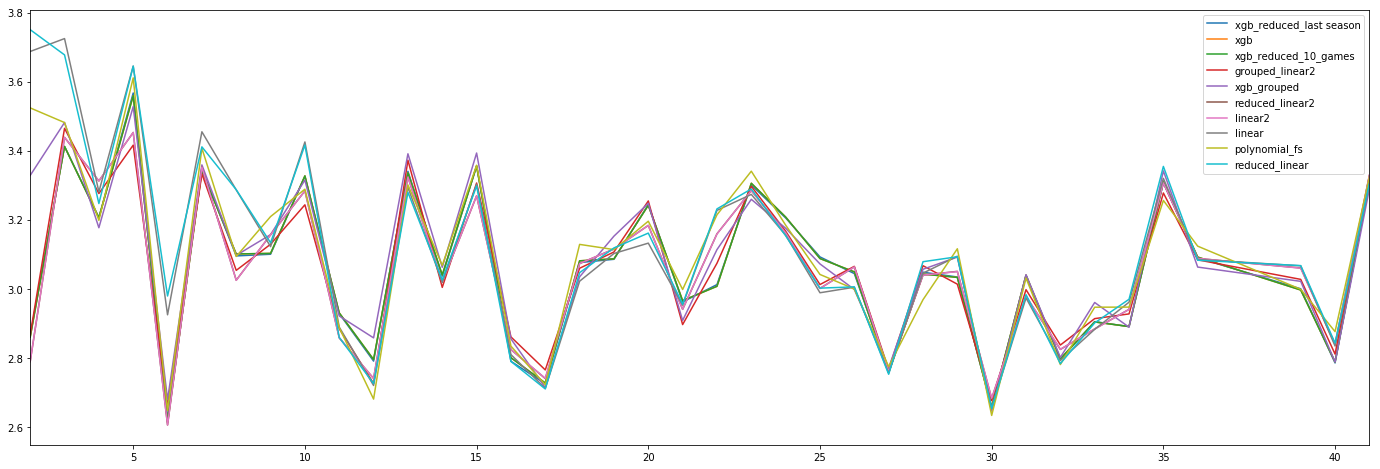

In [8]:
df[cols].plot(figsize=(24, 8))

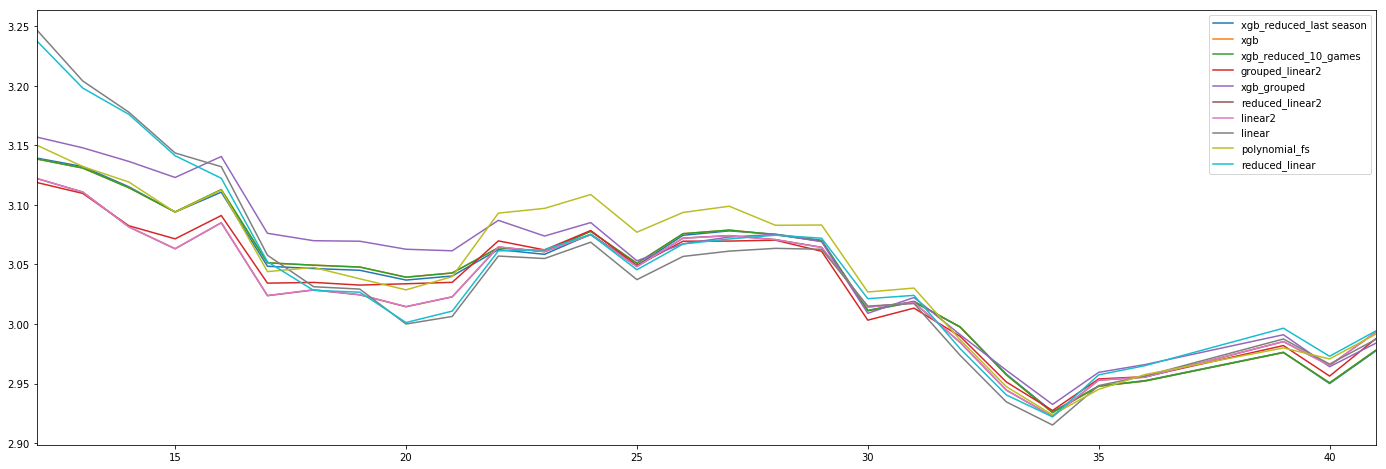

In [9]:
df[cols].rolling(10).mean().iloc[10:].plot(figsize=(24, 8))

In [ ]:
df.ewm(halflife=10).mean().iloc[10:].plot(figsize=(24, 8))

In [119]:
df[["web_name", "gameweek", "season", "total_points", "target"]]

,web_name,gameweek,season,total_points,target
0,Ospina,1,2016.0,0.0,0.0
1,Ospina,2,2016.0,0.0,0.0
2,Ospina,3,2016.0,0.0,0.0
3,Ospina,4,2016.0,0.0,0.0
4,Ospina,5,2016.0,0.0,0.0
5,Ospina,6,2016.0,0.0,0.0
6,Ospina,7,2016.0,0.0,0.0
7,Ospina,8,2016.0,0.0,0.0
8,Ospina,9,2016.0,0.0,0.0
9,Ospina,10,2016.0,0.0,0.0


In [113]:
pd.read_csv("data/features.csv", header=None)[1]

0                              appearances
1                     appearances_mean_all
2                      appearances_sum_all
3                      big_chances_created
4             big_chances_created_mean_all
5                       big_chances_missed
6              big_chances_missed_mean_all
7                                      bps
8                             bps_mean_all
9                             element_type
10                          goals_conceded
11                 goals_conceded_mean_all
12                            goals_scored
13                   goals_scored_mean_all
14                     last_season_minutes
15                      last_season_points
16                         last_season_ppm
17                                 minutes
18                        minutes_mean_all
19                           opponent_team
20                             target_home
21                             target_team
22                            total_points
23         

In [133]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
y = df.target_minutes.dropna() > 60
X = df[df.columns[df.columns.str.startswith("appear")]].loc[y.index]
dfreg = df.loc[y[y==1].index]

features = [
    "last_season_ppm",
    "target_home",
    "goals_conceded_target_team_mean",
    "target_team",
    "last_season_points",
    "element_type"
]
Xreg = dfreg[features]
yreg = dfreg.target
Xreg.shape, yreg.shape

((8341, 6), (8341,))

In [134]:
yreg

26        2.0
37        6.0
38        4.0
39        1.0
40        1.0
41        6.0
42        6.0
43        2.0
44        7.0
45        1.0
46        2.0
47        3.0
48        2.0
49        2.0
50        3.0
51        1.0
52        2.0
53        6.0
54        7.0
55        2.0
56        7.0
57        4.0
58        2.0
59        2.0
60        7.0
61        2.0
66        3.0
67        7.0
68        4.0
69        8.0
         ... 
25327     1.0
25329     3.0
25330     2.0
25331    15.0
25332     2.0
25344     2.0
25345     3.0
25347     3.0
25349    11.0
25350     3.0
25351     3.0
25352     2.0
25394     1.0
25404     2.0
25405     2.0
25406     2.0
25408     2.0
25410     1.0
25427     9.0
25428     2.0
25430     2.0
25431     3.0
25433     6.0
25434     6.0
25440     5.0
25448     1.0
25449     7.0
25454     3.0
25455     2.0
25471     3.0
Name: target, Length: 8341, dtype: float64

In [138]:
model = XGBRegressor(n_estimators=32)
p = cross_val_predict(model, Xreg, yreg)
mean_squared_error(yreg, p)**0.5

3.0416428581947907

In [149]:
from sklearn.base import BaseEstimator, RegressorMixin
class GroupedModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimator, groupby):
        self.estimator = estimator
        self.groupby = groupby
        self.models = {}

    def fit(self, X, y, **kwargs):
        for name in X[self.groupby].unique():
            filt = X[self.groupby]==name
            self.models[name] = self.estimator.fit(X[filt], y[filt], **kwargs)
        return self

    def predict(self, X, **kwargs):
        preds = np.zeros(X.shape[0])
        for name in X[self.groupby].unique():
            filt = X[self.groupby]==name
            preds[filt] = self.models[name].predict(X[filt], **kwargs)
        return preds

    def predict_proba(self, X, **kwargs):
        preds = np.zeros(X.shape[0])
        for name in X[self.groupby].unique():
            filt = X[self.groupby]==name
            preds[filt] = self.models[name].predict(X[filt], **kwargs)
        return preds


In [150]:
gmodel = GroupedModel(model, "element_type")
p = cross_val_predict(gmodel, Xreg, yreg)
mean_squared_error(yreg, p)**0.5

3.1196190619295137